In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter
import math
from os import listdir
import random
import cv2

import pywt

import keras
from keras import backend as K
from keras.models import model_from_json
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam
from keras import regularizers, optimizers, losses, initializers

import tensorflow as tf
from tensorflow.python.client import device_lib

/home/aimee/App/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%run srcnn.py

In [3]:
print(device_lib.list_local_devices())
print(K.tensorflow_backend._get_available_gpus())

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
session = tf.Session(config=config)
keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6415549341713644643
]
[]


### Load images

In [4]:
PATH = "../"
TRAIN_FILE = PATH + "datasets/DIV2K_train_HR/"
TEST_FILE = PATH +"datasets/DIV2K_train_LR_wild/"
VALID_HR = PATH +"datasets/DIV2K_valid_HR/"
VALID_LR = PATH +"datasets/DIV2K_valid_LR_wild/"
obj_files = listdir(TRAIN_FILE )
valid_files = listdir(VALID_HR )

In [5]:
valid_files[:5]

['0897.png', '0887.png', '0806.png', '0834.png', '0896.png']

In [6]:
def convertToYCbCr(x):
    return [image.convert('YCbCr') for image in x]

In [7]:
#Display images
def print_luminance(img, ch=1) :
    if (ch == 1) :
        plt.imshow(img, cmap=plt.get_cmap('gray'), interpolation='nearest')
    else :
        plt.imshow(img[:,:,0], cmap=plt.get_cmap('gray'), interpolation='nearest')

In [8]:
#Load images

obj_img = []
train_img = []
valid_hr_img = []
valid_lr_img= []

for i in range(0,64): #should be replaced here with something random at some point
    n = obj_files[i]
    m = valid_files[i]
    obj_img.append(Image.open(TRAIN_FILE + n))
    
#Only consider the luminance channel (YCrCb)
ycbcr_obj = convertToYCbCr(obj_img)

In [9]:
ycbcr_obj[0].size

(2040, 1140)

In [10]:
#Convert images to numpy array
imgs_hd = [np.asarray(image)[:,:,0] for image in ycbcr_obj]

(1368, 2040)


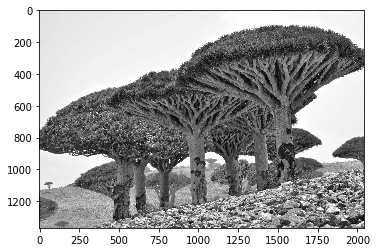

In [11]:
print(imgs_hd[1].shape)
print_luminance(imgs_hd[1])

### Generate train and test set

In [12]:
def getSubImage(img, height, width, centerX, centerY, len_interval, scale = 1) :
    window = window_size // scale
    return img[ height   : height//2 + window + centerX*len_interval,
                width // 2  + centerY*len_interval : width//2 + window + centerY*len_interval : ]

In [13]:
def retSize(x):
    return (x.shape[0], x.shape[1])

In [14]:
#Division by 4
window_size= 32
scale = 4
stride = 32
subimages_per_axis = 4

In [15]:
def getSubImages(image, stride = stride) :
    sub = []
    height, width = retSize(image)
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            sub.append(image[h : h + window_size, w : w + window_size])
    return sub

In [16]:
sub_labels = []
sub_samples = []
sub_valid_hr = []
sub_valid_lr = []

for i in range(0,64) :
    label, sample = get_input_images(imgs_hd[i], 4)
    
    #len_interval = height_sample//subimages_per_axis
    
    #Calculate subimages
    sub_labels += getSubImages(label)
    sub_samples += getSubImages(sample)

In [17]:
len(sub_labels)

168588

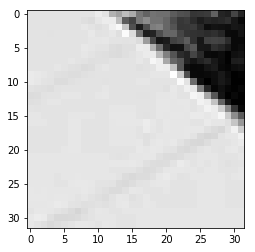

In [18]:
print_luminance(sub_labels[0])

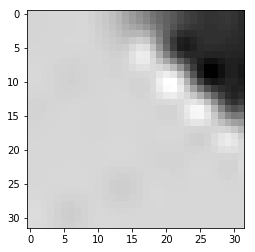

In [19]:
print_luminance(sub_samples[0])
#sub_samples[1].shape

#### Generate the wavelets subbands

In [20]:
def appendSubbands(l1,l2,l3,l4, dwt):
    l1 = np.append(l1 , dwt[0])
    l2 = np.append(l2, dwt[1][0])
    l3 = np.append(l3, dwt[1][1])
    l4 = np.append(l4, dwt[1][2])
    return (l1,l2,l3,l4)

In [21]:
def plot4images(im1, im2, im3, im4, ch=1) :
    size = (10, 10)
    fig = plt.figure(figsize=size)
    
    plt.subplot(221)
    plt.title("Approximation")
    print_luminance(im1, ch )
    plt.subplot(222)
    plt.title("Horizontal")
    print_luminance(im2, ch)
    plt.subplot(223)
    plt.title("Vertical")
    print_luminance(im3, ch)
    
    plt.subplot(224)
    plt.title("Diagonal")
    print_luminance(im4, ch)

def plot_waveletTrans(wt, ch=1) :
    plot4images(wt[0], wt[1][0], wt[1][1], wt[1][2], ch)

(21, 21)


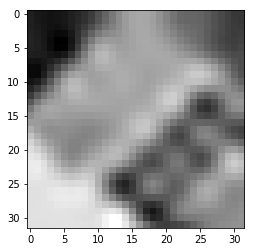

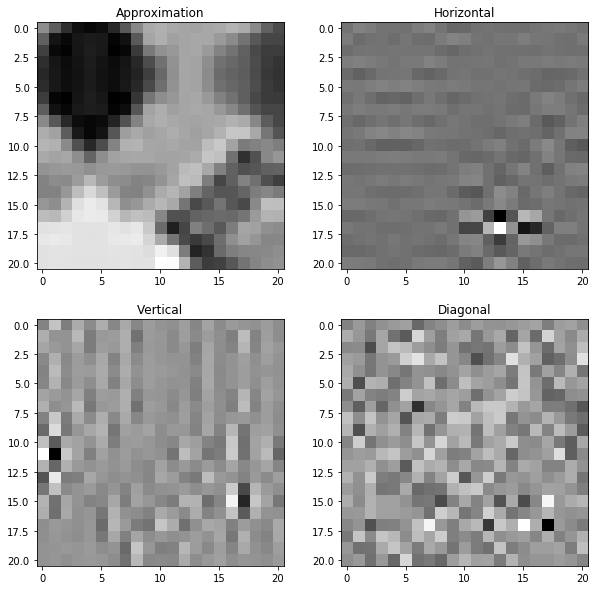

In [22]:
x_sample = sub_samples[1]
print_luminance(x_sample)
x_dwt = pywt.dwt2(x_sample, 'db6')
print(x_dwt[0].shape)
plot_waveletTrans(x_dwt)

436.98245256623636


numpy.ndarray

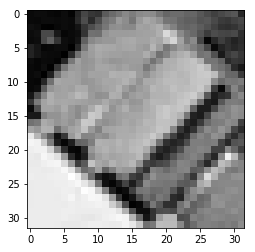

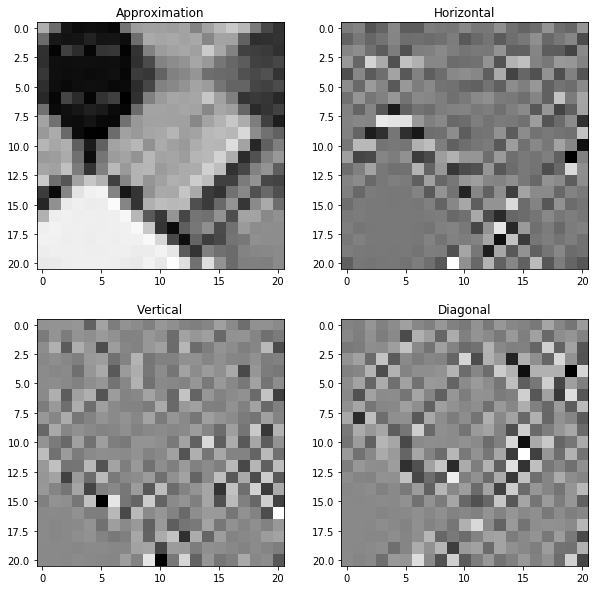

In [23]:
y_sample = sub_labels[1]
print_luminance(y_sample)
y_dwt = pywt.dwt2(y_sample, 'db6')
print(y_dwt[0].max())
plot_waveletTrans(y_dwt)
type(y_dwt[1][1])

In [24]:
pepe = np.asfarray([y_dwt[0], y_dwt[1][0], y_dwt[1][1], y_dwt[1][2]])
pepe.max()

436.98245256623636

In [25]:
shape = 32

test_list = []
train_list = []
for i in range(len(sub_labels)):
    y = sub_labels[i]
    x = sub_samples[i]
    
    dwt_y = pywt.dwt2(y, 'db6')
    dwt_x = pywt.dwt2(x, 'db6')    
    
    
    hight = np.asfarray([dwt_y[0], dwt_y[1][0], dwt_y[1][1], dwt_y[1][2]])
    x = np.asfarray([dwt_x[0], dwt_x[1][0], dwt_x[1][1], dwt_x[1][2]])
    
    y = hight - x
    
    test_list.append(y)
    train_list.append(x)

In [26]:
def equals(a, b) :
    t = a == b
    count = 0
    for a in range(0, len(t)) :
        for b in range(len(t[0])) :
            for c in range(len(t[1])) :
                if ( t[a, b, c] == False):
                    count = count + 1
    return count / (32*32*4) < 0.20
    

In [27]:
len(test_list)

168588

In [28]:
max_ = 0
for i in range(len(test_list)) :
    tmp = test_list[i].max()
    if (tmp > max_ ) :
        max_ = tmp
max_

535.2009390037549

In [29]:
test = np.asarray(test_list)
train = np.asarray(train_list)

#print(test.max())

#test = test / 255.
#train = test / 255.

In [30]:
test.shape

(168588, 4, 21, 21)

In [31]:
equals(train[10], test[10])

False

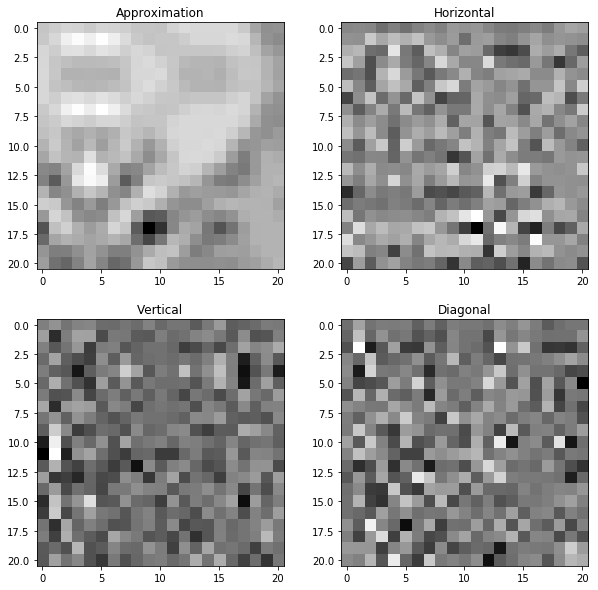

In [32]:
sample = train[10]
plot4images(sample[0], sample[1], sample[2], sample[3])

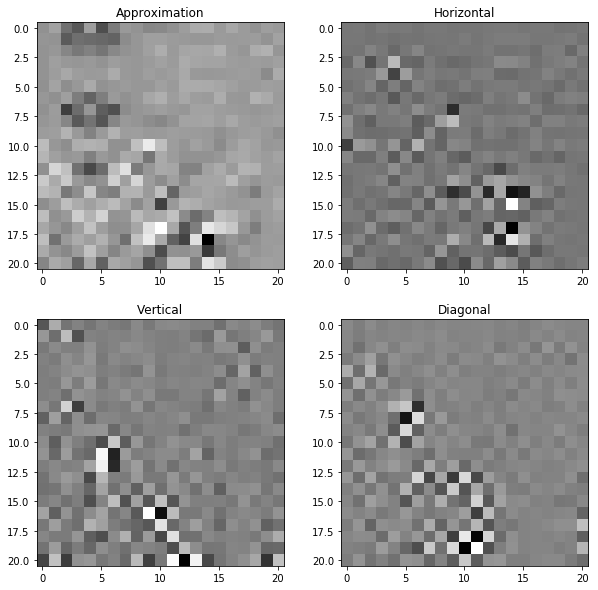

In [33]:
label = test[10]
plot4images(label[0], label[1], label[2], label[3])

#### Creating and Training the networks

In [34]:
def reshape(matrix, dwt_shape, channel='channels_last', ch=1) :
    if (channel == 'channels_last') :
        return matrix.reshape(-1, dwt_shape[0], dwt_shape[1], ch)
    else :
        return matrix.reshape(ch, -1, dwt_shape[0], dwt_shape[1])

In [35]:
input_shape = train.shape
input_shape
shape_ = (input_shape[1],input_shape[2], input_shape[3])

In [36]:
window_size

32

In [37]:
kernel_ini = initializers.RandomNormal(mean=0.0, stddev=1e-3, seed=None)
bias_ini = keras.initializers.Zeros()

adam = optimizers.Adam() 

In [38]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5,5),strides=(1,1),padding='same',
                 activation='selu',
                 input_shape=shape_,
                 kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini,
                 data_format='channels_first'))
for i in range(10) :
    model.add(Conv2D(64, (3, 3),strides=(1,1), activation='selu', padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

    
model.add(Conv2D(4, (3, 3),strides=(1,1), padding='same', kernel_initializer=kernel_ini,
                 bias_initializer=bias_ini, data_format='channels_first'))

model.compile(optimizer=Adam(),
             loss='mean_absolute_error')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 21, 21)        6464      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 21, 21)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 21, 21)        36928     
__________

In [ ]:
history_CNN = model.fit(train, test, validation_split=0.2, epochs=1, batch_size=64, verbose=1)

In [ ]:
save_model(model, "SRCNN_deep")

In [40]:
model = load_model("SRCNN_deep")

#### Original image and bicubic interpolated image

In [41]:
def patch_to_image(patches, height, width, strides=stride) :
    count = 0
    window_size =32
    
    img = np.zeros((height, width))
    for h in range(0, height - window_size, stride) :
        for w in range (0, width - window_size, stride) : 
            img[h : h + window_size, w : w + window_size] = \
                                            (img[h : h + window_size, w : w + window_size] + patches[count])/2
            count = count + 1
        
    assert(len(patches) == count)
    return img

In [42]:
valid = listdir(VALID_HR)
index = -1

In [43]:
im = Image.open(VALID_HR + "/" + valid[index])

img = np.asarray(im.convert('YCbCr'))

img = img[:,:,0]
org, bic = get_input_images(img, 4)

h, w = retSize(org)
org.shape

(1356, 2040)

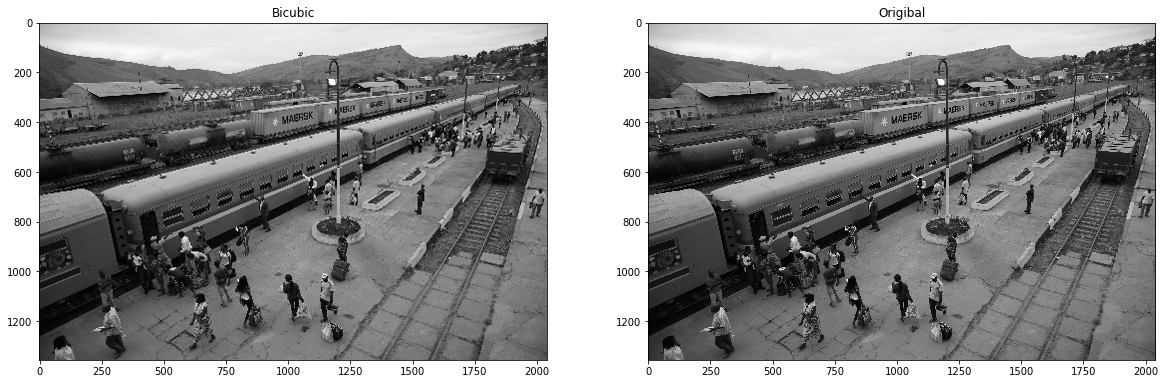

In [44]:
plot_images([org, bic], ["Origibal", "Bicubic"], size=(20, 10), ch=1)

In [45]:
sub_img = getSubImages(bic)
sub_img[0].shape

(32, 32)

In [46]:
low_w = []
for i in range(len(sub_img)):
    dwt_w = pywt.dwt2(sub_img[i], 'db6')
    
    dwt_w = np.asfarray([dwt_w[0], dwt_w[1][0], dwt_w[1][1], dwt_w[1][2]])
    
    low_w.append(dwt_w)


In [47]:
low_wavelet = np.asarray(low_w)
low_wavelet.shape

(2646, 4, 21, 21)

In [ ]:
pred_w = model.predict(low_wavelet)

In [ ]:
res = low_wavelet + pred_w

sub_imgs = []
for i in range(len(res)) :
    patch = res[i]
    dwt = (patch[0], (patch[1], patch[2], patch[3]))
    wavelet = pywt.idwt2(dwt, 'db6')
    sub_imgs.append(wavelet)

In [ ]:
sub_imgs[0].shape

In [ ]:
im = patch_to_image(sub_imgs, h, w, strides=16)

In [ ]:
fig = plt.figure(figsize=(20, 10))
print_luminance(im)

In [ ]:
fig = plt.figure(figsize=(20, 10))
print_luminance(img)